In [10]:
# Demo for yield data
import json

import geopandas as gpd
import pandas as pd

%pip install rasterio
import rasterio as rio
from shapely.geometry import Point
import matplotlib.pyplot as plt
from rasterio.plot import show

import os
import glob
import json
from datetime import datetime
from pathlib import Path
import re

DEPRECATION: Loading egg at /home/dlassahn/Dev/WorldCrops/env/lib/python3.11/site-packages/selfsupervised-0.0.3-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
# helper functions


def get_timestamp(meta_path):
    ''' get timestamp from meta file'''
    if Path(meta_path).exists():
        with open(meta_path, "r") as file:
            json_string = file.read()
            data = json.loads(json_string)
            date_regex = r"(\d{4}-\d{2}-\d{2})"
            date = re.search(r"TIME=" + date_regex, data['url'])

            timestamp = date.group(1)
            return datetime.strptime(timestamp, '%Y-%m-%d').date()
    else:
        return None  # or raise an exception, or return a default value


def get_directory_meta_information(data_dir):
    ''' get the meta information from a directory with fields and satellite images'''
    image_info = []

    for directory in glob.glob(os.path.join(data_dir, '*/')):
        name = os.path.basename(os.path.normpath(directory))

        # Iterate over all time series data for a field
        for _, data in enumerate(glob.glob(os.path.join(directory, '*/'))):
            image_id = os.path.basename(os.path.normpath(data))
            file = os.path.join(data, 'response.tiff')
            meta = os.path.join(data, 'request.json')

            try:
                # Check if files exist before retrieving metadata
                if Path(file).exists() and Path(meta).exists():
                    timestamp = get_timestamp(meta)
                    image_info.append((name, image_id, file, timestamp))
                else:
                    print(f"Files not found for {name}/{image_id}")

            except BaseException as error:
                print(f'An exception occurred: {error}, Image_id: {image_id}')

    return image_info


def plot(image, factor=1, _min=0, _max=1):
    """
    visualize satellite images
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1), vmin=_min, vmax=_max)
    else:
        plt.imshow(image, vmin=_min, vmax=_max)

In [12]:
# every image has 19 bands with 66 x 31 pixels
# Image bands:
# ["CLM", "dataMask", "B01", "B02", "B03", "B04","B05", "B06","B07", "B08","B8A", "B09", "B11","B12", sunAzimuthAngles, sunZenithAngles, viewAzimuthMean, viewZenithMean, NDWI]
# CLM stands for clouds 1 / no clouds 0
# there are also meta information and an index

# Data characteristics:
# Satellite: Sentinel-2
# time_interval:'2018-03-01' - '2018-07-30'
# Level: L2A
# Winter Wheat fields: 'Baumacker', 'D8', 'Dichtlacker', 'Heindlacker', 'Heng', 'Holzacker', 'Neulandsiedlung', 'Itzling2', 'Itzling5',
# 'Itzling6', 'Schluetterfabrik','Thalhausen138', 'Thalhausen141', 'Voettingerfeld'

Load data

In [13]:
# spatial field yield data from a combine harvester
yields = pd.read_csv('../data/cropdata/Bavaria/yields/yields2018.csv',
                     sep=",",
                     encoding="ISO-8859-1",
                     engine='python')
yields = yields[[
    'Name', 'Latitude', 'Longitude', 'Elevation(m)',
    'Ertr.masse (Nass)(tonne/ha)', 'Ertr.masse (Tr.)(tonne/ha)',
    'Ertr.vol (Tr.)(L/ha)', 'ErtragNass', 'ErtragTr', 'Feuchtigkeit(%)',
    'Jahr', 'TAG'
]]

# linear interpolated on a weekly basis for winter wheat
training = pd.read_excel(
    "../data/cropdata/Bavaria/yields/result_split_S2A_linear_W_WW_2018.xlsx")
# not interpolated daily data/ weather is daily
daily_training = pd.read_excel(
    "../data/cropdata/Bavaria/yields/satellite_data_orginal.xlsx")
# summary with nitrogen, yield and polygon ..."field-level yield in dt/ha !"
summary = pd.read_excel("../data/cropdata/Bavaria/yields/fields_summary.xlsx")

In [14]:
# list all fields
# WW stands for Winter Wheat
# WG stands for Winter barley
# 1D Time series are only for WW available

print('Winter Wheat:', summary[summary.Type == 'WW']['Name'].unique())
print('Winter Barley:', summary[summary.Type == 'WG']['Name'].unique())

# choose a field for plots
field_name = 'Dichtlacker'

Winter Wheat: ['Baumacker' 'D2' 'D3' 'D4' 'D8' 'Dichtlacker' 'Feldhof1' 'Feldhof1a'
 'Feldhof1b' 'Feldhof2' 'Heindlacker' 'Heng' 'Holzacker' 'Itzling2'
 'Itzling4' 'Itzling5' 'Itzling6' 'Muehlacker' 'Neulandsiedlung'
 'Schluetterfabrik' 'Thalhausen138' 'Thalhausen141' 'Thalhausen86'
 'Voettingerfeld']
Winter Barley: ['Grafenfeld' 'Krohberg' 'Radarstation' 'Sieblerfeld' 'Striegelfeld'
 'Viehhausen1' 'Viehhausen11' 'Viehhausen3' 'Viehhausen5']


Yield data from the combine harvester

/home/dlassahn/Dev/WorldCrops/env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


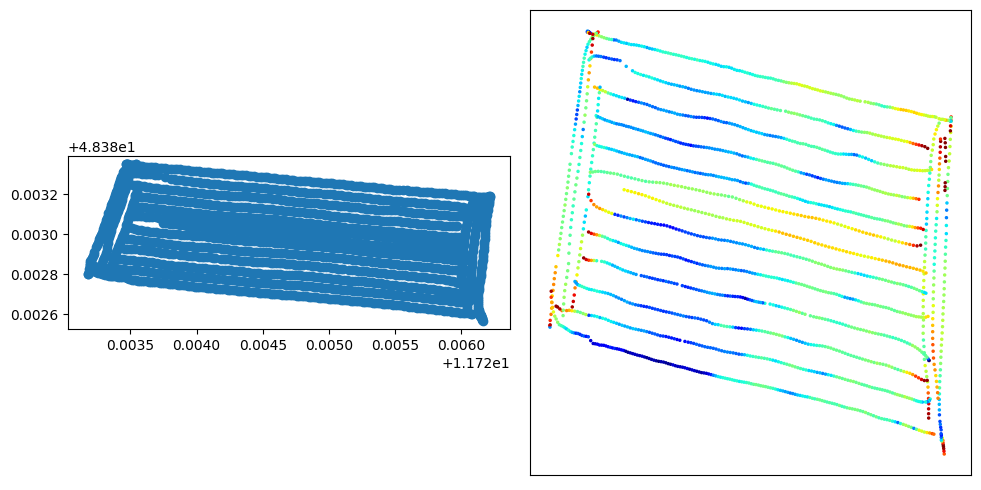

In [15]:
# plot the corresponding combine harvester data for the same field

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

size = 40

field = yields[yields.Name == field_name]
geometry = [Point(xy) for xy in zip(field.Longitude, field.Latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(field, crs=crs, geometry=geometry)

minx, miny, maxx, maxy = gdf.total_bounds

ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.scatter(y=field.Latitude,
            x=field.Longitude,
            alpha=1,
            cmap=plt.get_cmap("jet_r"),
            c=field['Ertr.masse (Nass)(tonne/ha)'],
            s=2.2)
gdf.plot(ax=ax1)
f.tight_layout()

plt.show()

   Unnamed: 0         Name  Jahr     Ertrag  ErtragNass Type   Latitude  \
5          10  Dichtlacker  2018  58.515511   58.515511   WW  48.382564   

   Longitude  Duenger_1  N_1  ...     Datum_3  Duenger_4 N_4  P_4  K_4  \
5  11.726162        NaN  NaN  ...  2018-05-22        NaN NaN  NaN  NaN   

   Datum_4     Aussaat Ernte  TAG  \
5      NaN  2017-10-10   NaN  UNI   

                                             Polygon  
5  POLYGON ((11.72614981180946 48.38255434857475,...  

[1 rows x 32 columns]


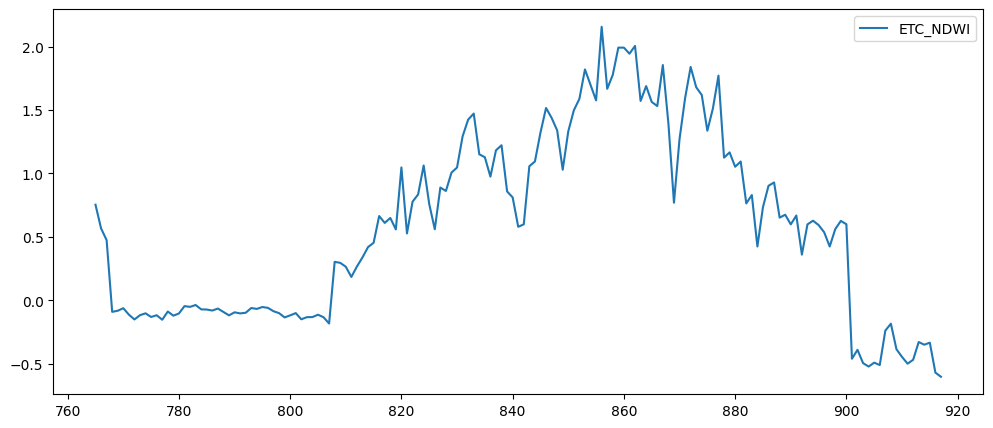

In [16]:
# plot corresponding 1D timeseries
# The dataset includes daily water needs, raw bands, indices, weather etc.

fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
daily_training[daily_training.Name == field_name][['ETC_NDWI']].plot(ax=ax1)

# field = summary[summary.Name == field_name]
# field['Polygon'] = gpd.GeoSeries.from_wkt(field['Polygon'])
# gdf = gpd.GeoDataFrame(field, geometry='Polygon')
# gdf.plot(ax=ax1)

print(summary[summary.Name == field_name])

In [17]:
data_dir = '../data/cropdata/Bavaria/yields/sat_images_10m/'
metadata = get_directory_meta_information(data_dir)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


<AxesSubplot:title={'center':'blue channel'}>

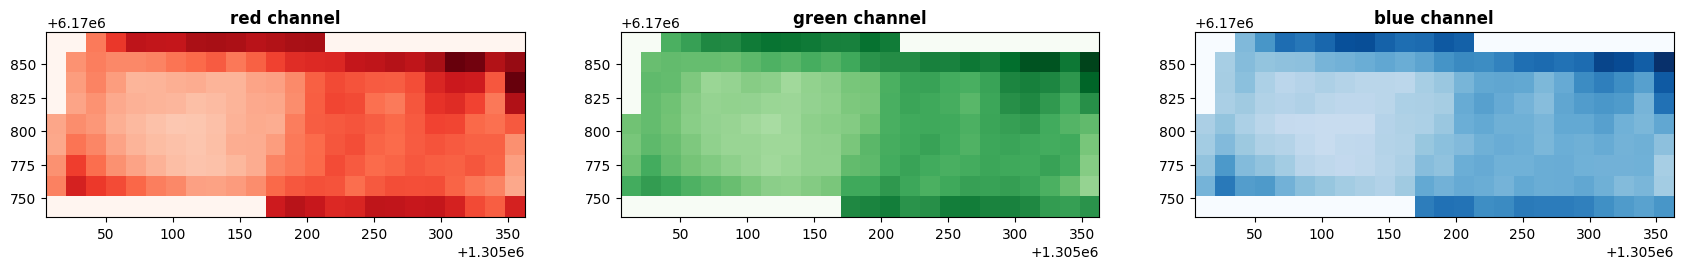

In [18]:
# plot the corresponding satellite data for this field

# Filtering data
filtered_data = [item for item in metadata if item[0] == field_name]
fp1 = filtered_data[0][2]

raster1 = rio.open(fp1)

# data description:
# ["CLM", "dataMask", "B01", "B02", "B03", "B04","B05", "B06","B07", "B08","B8A", "B09", "B11","B12"]

fig, (axr, axg, axb) = plt.subplots(1, 3, figsize=(21, 7))
show((raster1, 6), ax=axr, cmap='Reds', title='red channel')
show((raster1, 5), ax=axg, cmap='Greens', title='green channel')
show((raster1, 4), ax=axb, cmap='Blues', title='blue channel')